In [17]:
import sys
import logging
import os
import json
from tqdm import tqdm
import warnings
from IPython.display import display

import numpy as np

import torch
import torchvision.transforms as T

from dalle_pytorch import OpenAIDiscreteVAE

sys.path.append('..')
logging.getLogger().setLevel(logging.INFO)
warnings.filterwarnings('ignore')

from aural_travels.data import soundcloud
from aural_travels.model import AudioDALLE

# Adjust this to your local copy of the SoundCloud dataset.
# Should contain the `scdata.json` file and the `audio` directory.
MODEL_DIR = '/home/leo/src/aural-travels/models/poc'

In [2]:
with open(os.path.join(MODEL_DIR, 'params.json')) as f:
    params = json.load(f)

In [3]:
params

{'soundcloud_data_dir': '/home/leo/src/scdata',
 'dataset': 'soundcloud',
 'num_workers': 32,
 'batch_size': 10,
 'num_epochs': 10,
 'hidden_size': 256,
 'num_layers': 8,
 'num_heads': 256,
 'attention_dropout': 0.1,
 'ffnn_dropout': 0.01,
 'lr': 0.001,
 'output_dir': 'models/poc',
 'sample_secs': 2.0,
 'save_steps': 100,
 'encoding_dir': 'models/encoding',
 'seed': 42,
 'n_fft': 2048,
 'hop_length': 1024}

In [4]:
vae = OpenAIDiscreteVAE()
vae.eval()

dataset = soundcloud.CoverGenerationDataset(data_dir=params['soundcloud_data_dir'],
                                            split='validation',
                                            image_labels=None,
                                            sample_secs=params['sample_secs'],
                                            n_fft=params['n_fft'],
                                            hop_length=params['hop_length'])
model = AudioDALLE(vae=vae,
                   audio_seq_len=dataset.num_samples(),
                   audio_num_features=dataset.num_features(),
                   hidden_size=params['hidden_size'],
                   num_layers=params['num_layers'],
                   num_heads=params['num_heads'],
                   attention_dropout=params['attention_dropout'],
                   ffnn_dropout=params['ffnn_dropout'])
model.eval().to('cuda')

AudioDALLE(
  (vae): OpenAIDiscreteVAE(
    (enc): Encoder(
      (blocks): Sequential(
        (input): Conv2d(n_in=3, n_out=256, kw=7, use_float16=True, device=device(type='cpu'), requires_grad=False)
        (group_1): Sequential(
          (block_1): EncoderBlock(
            (id_path): Identity()
            (res_path): Sequential(
              (relu_1): ReLU()
              (conv_1): Conv2d(n_in=256, n_out=64, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
              (relu_2): ReLU()
              (conv_2): Conv2d(n_in=64, n_out=64, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
              (relu_3): ReLU()
              (conv_3): Conv2d(n_in=64, n_out=64, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
              (relu_4): ReLU()
              (conv_4): Conv2d(n_in=64, n_out=256, kw=1, use_float16=True, device=device(type='cpu'), requires_grad=False)
            )
          )
          (block_2): 

In [5]:
checkpoint = torch.load(os.path.join(MODEL_DIR, 'last_checkpoint.pt'))
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [6]:
checkpoint['global_step']

5800

In [20]:
indices = list(range(32))

audios = [] 
for idx in indices:
    audios.append(dataset[idx][0][None, :, :])
    
audios = torch.cat(audios, dim=0).to('cuda')
print(audios.size())

TypeError: cat() received an invalid combination of arguments - got (Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, device=str), but expected one of:
 * (tuple of Tensors tensors, name dim, *, Tensor out)
 * (tuple of Tensors tensors, int dim, *, Tensor out)


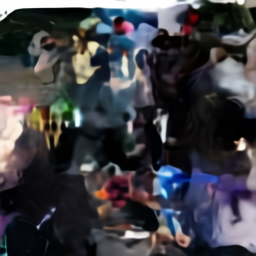

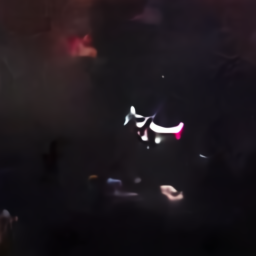

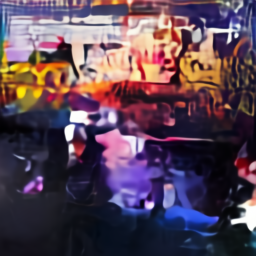

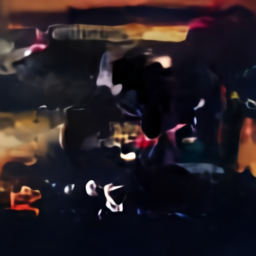

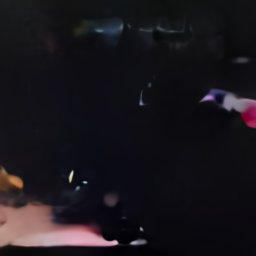

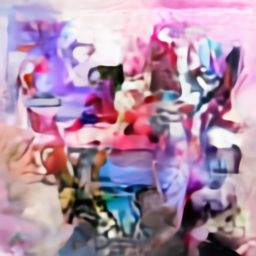

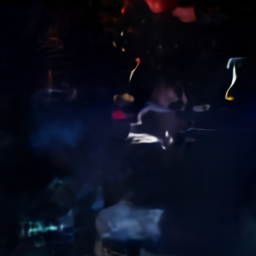

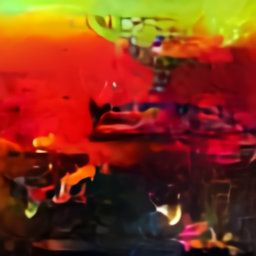

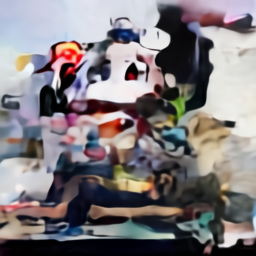

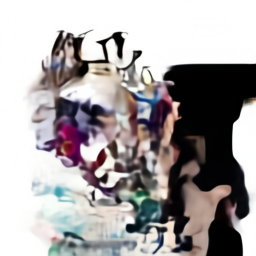

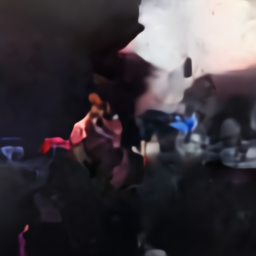

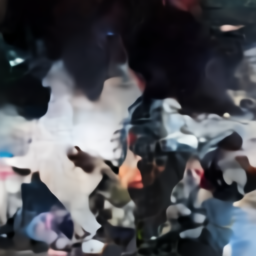

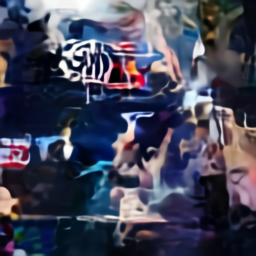

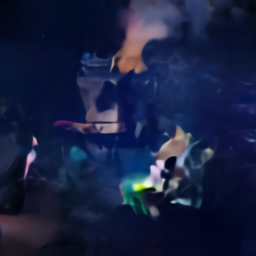

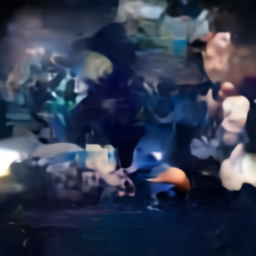

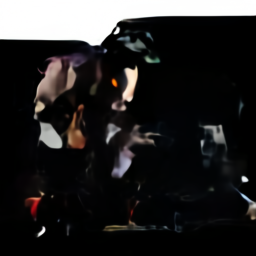

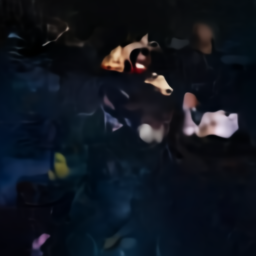

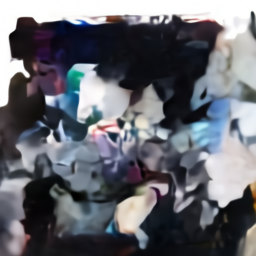

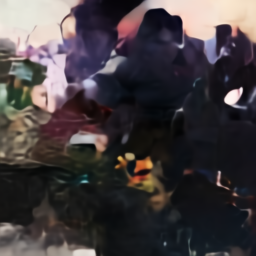

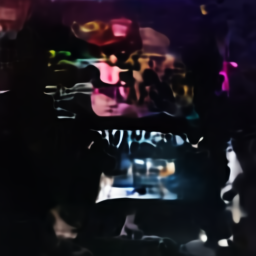

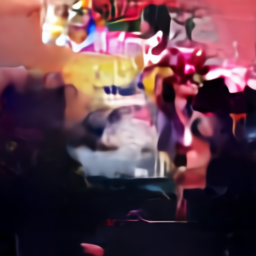

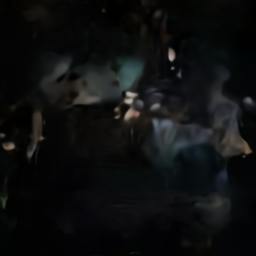

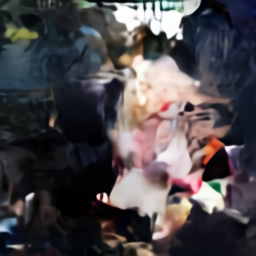

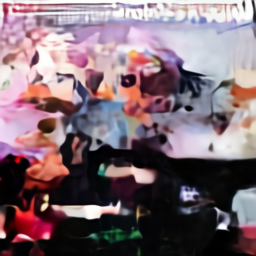

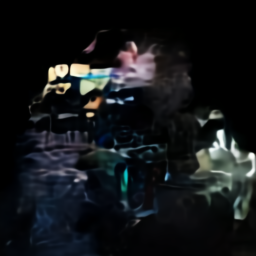

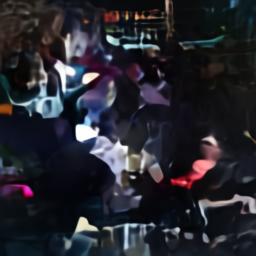

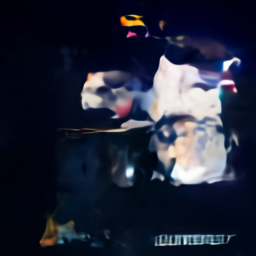

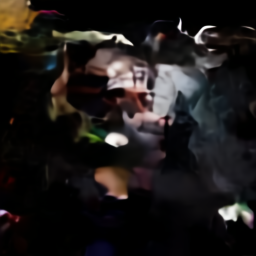

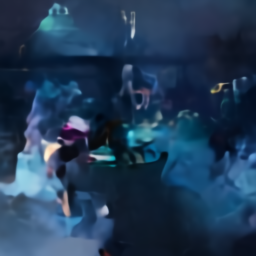

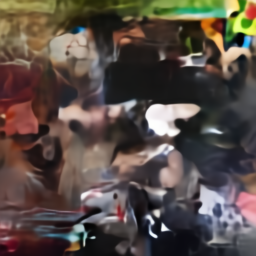

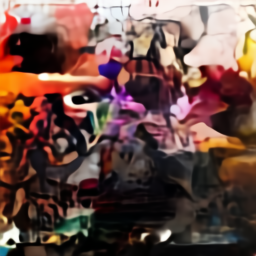

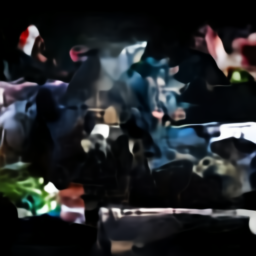

In [23]:
images = model.generate_images(audios)
for image in images:
    display(T.ToPILImage(mode='RGB')(image))